# Recommendation System Notebook
- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

Different Approaches to develop Recommendation System -

1. Demographich based Recommendation System

2. Content Based Recommendation System

3. Collaborative filtering Recommendation System

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import dedent
from imblearn.over_sampling import SMOTE
# from pycaret.classification import setup, compare_models
import en_core_web_sm
from nltk.tokenize import word_tokenize
# from pycaret.classification import *

# nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
reviews_dataset=pd.read_csv('/content/drive/MyDrive/Capstone_Project_Sentiment_Analysis/sample30.csv')

In [7]:
reviews_dataset.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [8]:
reviews_dataset.shape

(30000, 15)

In [9]:
reviews_dataset.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [10]:
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### In order to decide which columns are needed, we can find the description of the columns in "Data+Attribute+Description.csv"

In [11]:
column_descriptions = pd.read_csv(
    '/content/drive/MyDrive/Capstone_Project_Sentiment_Analysis/Data+Attribute+Description.csv',
    encoding='ISO-8859-1'     # or simply 'latin1'
)

In [12]:
# show every character in any column
pd.set_option('display.max_colwidth', None)   # or a large int, e.g. 200

# if the frame still wraps across two lines, widen the overall table:
pd.set_option('display.width', 0)             # 0 = auto-detect terminal width
pd.set_option('display.expand_frame_repr', False)

In [13]:
column_descriptions

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


### In order to create machine learning models that track sentiment, the following columns are relevant:


- id: Unique reviews retained to be able to retain accuracy & control over the data
-	name:	Provides context for recommendations and enables product-specific sentiment analysis
- reviews_text:	Primary feature containing user opinions and sentiments expressed in natural language
- reviews_title:	Will be combined with reviews_text to form the primary feature containing user opinions
-	user_sentiment:	The overall sentiment of the user for a particular product (Positive or Negative), which will be the ground truth labels (Positive/Negative) for supervised learning model training


### Columns to be dropped:
This project emphasizes natural language processing capabilities by relying exclusively on textual review content for sentiment determination. Consequently the following columns do not have textual content that will help with the analysis:

brand	Name/ categories/ manufacturer/ reviews_date/ reviews_userCity/ reviews_userProvince/ reviews_username/ reviews_didPurchase/ reviews_doRecommend/ reviews_rating:	 - will be dropped due to not directly linked to assessing user sentiment. Numerical ratings are excluded to focus purely on sentiment derived from textual content.









In [14]:
df_data = reviews_dataset[['id', 'name', 'reviews_title',
                           'reviews_text', 'user_sentiment']].copy()

In [15]:
df_data.head()

,id,name,reviews_title,reviews_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good,Good flavor. This review was collected as part of a promotion.,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good,Good flavor.,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Negative


### Feature Engineering
#### Combine reviews_title and reviews_text to create a new text column

In [16]:
df_data['combined_review'] = df_data.apply(
    lambda row: f"{row['reviews_title']} {row['reviews_text']}".strip()
    if pd.notnull(row['reviews_title']) or pd.notnull(row['reviews_text'])
    else np.nan,
    axis=1
)

In [17]:

# Drop 'reviews_title' and 'reviews_text'
df_data.drop(columns=['reviews_title', 'reviews_text'], inplace=True)

In [18]:
# showing the new data set, which combines the review and drops the components - 'reviews_title' and 'reviews_text'
df_data.head()

,id,name,user_sentiment,combined_review
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Positive,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,Good Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Negative,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Negative,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [19]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               30000 non-null  object
 1   name             30000 non-null  object
 2   user_sentiment   29999 non-null  object
 3   combined_review  30000 non-null  object
dtypes: object(4)
memory usage: 937.6+ KB


There appears to be two areas where the data needs to be cleaned.
- Firstly the Dtypes are all of type "objects", whereas the name, user_sentiment and combined_review should be of type string
- Secondly there appears to be one null row in user_sentiment that should be dropped

In [20]:
# Convert all the text columns to string for performing text operations
df_data = df_data.astype({
    'name'            : 'string',
    'user_sentiment'  : 'string',
    'combined_review' : 'string'
})


In [21]:
# drop null row
df_data = df_data.dropna(subset=['user_sentiment'])

In [22]:
# Remove rows where user_sentiment is string 'nan', 'NaN', 'null', etc.
df_data = df_data[~df_data['user_sentiment'].isin(['nan', 'NaN', 'null', 'None', 'NULL'])]


In [23]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29999 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               29999 non-null  object
 1   name             29999 non-null  string
 2   user_sentiment   29999 non-null  string
 3   combined_review  29999 non-null  string
dtypes: object(1), string(3)
memory usage: 1.1+ MB


# Exploratory Data Analysis (EDA)

### EDA on User Sentiment

In [24]:
df_data['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


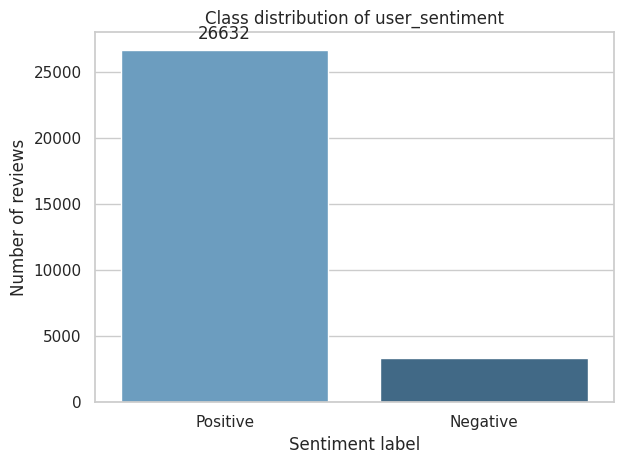

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1 – Tidy theme
sns.set_theme(style="whitegrid")

# 2 – Bar plot of class counts
ax = sns.countplot(
    x="user_sentiment",
    data=df_data,
    order=df_data["user_sentiment"].value_counts().index,  # Positive first
    palette="Blues_d"
)

# 3 – Add numeric labels on top of each bar
ax.bar_label(ax.containers[0], padding=5, fontsize=12)

# 4 – Polish the axes
ax.set(
    title="Class distribution of user_sentiment",
    xlabel="Sentiment label",
    ylabel="Number of reviews"
)

plt.tight_layout()
plt.show()


### EDA take-away on `user_sentiment`

> **Finding** – The dataset is heavily skewed toward *Positive* reviews (\~ 26 600, 89 %) versus *Negative* reviews (\~ 3 400, 11 %).
> **Implication** – Any supervised model trained directly on this distribution is likely to over-predict the majority class and under-detect negative sentiment, inflating overall accuracy while harming recall/precision for the minority class.

> **Conclusion** – I will look at correcting the class imbalance after the text-cleaning/vectorisation step and *only* on the training split (Using SMOTE).

### EDA on Combined Review Text

In [26]:
# ──────────────────────────────────────────────────────────────────────
# 1  Create / refresh a token-length column
# ──────────────────────────────────────────────────────────────────────
df_data = df_data.copy()   # avoid SettingWithCopy surprises
df_data["review_tokens"] = (
    df_data["combined_review"]
      .str.split()         # whitespace split (good enough for EDA)
      .str.len()
)

In [27]:
# ──────────────────────────────────────────────────────────────────────
# 2  Summary statistics and quick sanity check
# ──────────────────────────────────────────────────────────────────────
summary_tok = (df_data["review_tokens"]
               .describe(percentiles=[.5, .75, .9, .95, .99])
               .round(1))
print("Token-length summary over all reviews\n", summary_tok)

# Split by sentiment if you like:
print("\nMedian tokens per sentiment")
print(df_data.groupby("user_sentiment")["review_tokens"].median())

Token-length summary over all reviews
 count    29999.0
mean        37.6
std         35.1
min          2.0
50%         28.0
75%         44.0
90%         72.0
95%         96.0
99%        174.0
max       1015.0
Name: review_tokens, dtype: float64

Median tokens per sentiment
user_sentiment
Negative    26.0
Positive    28.0
Name: review_tokens, dtype: float64


In [28]:
# 4-A  Absolute threshold (example: 600 tokens)
ABS_LIM = 600
mask_abs = df_data["review_tokens"] > ABS_LIM
print(f"\nReviews > {ABS_LIM} tokens: {mask_abs.sum()} ({mask_abs.mean():.2%} of data)")


Reviews > 600 tokens: 4 (0.01% of data)


In [29]:
# 4-A  Absolute threshold (example: 400 tokens)
ABS_LIM = 400
mask_abs = df_data["review_tokens"] > ABS_LIM
print(f"\nReviews > {ABS_LIM} tokens: {mask_abs.sum()} ({mask_abs.mean():.2%} of data)")


Reviews > 400 tokens: 18 (0.06% of data)


In [30]:
# 4-A  Absolute threshold (example: 500 tokens)
ABS_LIM = 500
mask_abs = df_data["review_tokens"] > ABS_LIM
print(f"\nReviews > {ABS_LIM} tokens: {mask_abs.sum()} ({mask_abs.mean():.2%} of data)")


Reviews > 500 tokens: 9 (0.03% of data)


In [31]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29999 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               29999 non-null  object
 1   name             29999 non-null  string
 2   user_sentiment   29999 non-null  string
 3   combined_review  29999 non-null  string
 4   review_tokens    29999 non-null  int64 
dtypes: int64(1), object(1), string(3)
memory usage: 1.4+ MB


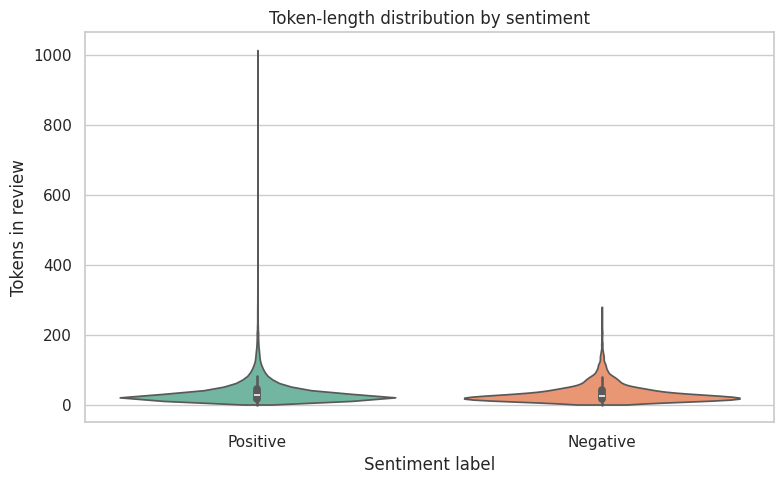

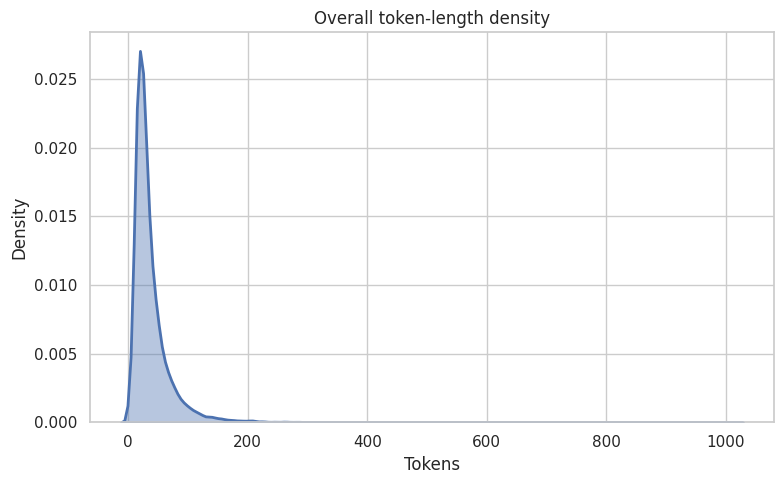

In [32]:
# ──────────────────────────────────────────────────────────────────────
# 3  Visualise the full distribution – keep outliers visible
# ──────────────────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.violinplot(
    y="review_tokens",
    x="user_sentiment",
    data=df_data,
    order=["Positive", "Negative"],
    palette="Set2",
    cut=0               # don’t extend violins beyond observed max
)
ax.set(title="Token‐length distribution by sentiment",
       xlabel="Sentiment label",
       ylabel="Tokens in review")
plt.tight_layout()
plt.show()

# KDE overlay for whole corpus
plt.figure(figsize=(8, 5))
sns.kdeplot(df_data["review_tokens"], fill=True, alpha=.4, linewidth=2)
plt.title("Overall token-length density")
plt.xlabel("Tokens"); plt.ylabel("Density")
plt.tight_layout(); plt.show()

In [33]:
# 4-A  Absolute threshold (example: 300 tokens)
ABS_LIM = 300
mask_abs = df_data["review_tokens"] > ABS_LIM
print(f"\nReviews > {ABS_LIM} tokens: {mask_abs.sum()} ({mask_abs.mean():.2%} of data)")


Reviews > 300 tokens: 47 (0.16% of data)


In [34]:
# 4-B  IQR rule
Q1, Q3 = np.percentile(df_data["review_tokens"], [25, 75])
IQR = Q3 - Q1
IQR_LIM = Q3 + 1.5 * IQR
mask_iqr = df_data["review_tokens"] > IQR_LIM
print(f"IQR threshold = {IQR_LIM:.1f} tokens  →  {mask_iqr.sum()} reviews flagged")

IQR threshold = 81.5 tokens  →  2225 reviews flagged


In [35]:
# 4-C  Top-1 % quantile
P99 = np.percentile(df_data["review_tokens"], 99)
mask_p99 = df_data["review_tokens"] > P99
print(f"99th-percentile = {P99:.0f} tokens  →  {mask_p99.sum()} reviews flagged")

99th-percentile = 174 tokens  →  296 reviews flagged


It appears that there are outliers of token length in the positive sentiment group, which could affect the accuracy of the model. In order to correct the outliers I will remove only 9 rows containing more than 500 tokens, which represents only 0.03 % of 29 999 records.	The data loss is negligible; class distribution remains intact.

In [36]:
df_data_clean = df_data.copy()

In [37]:
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29999 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               29999 non-null  object
 1   name             29999 non-null  string
 2   user_sentiment   29999 non-null  string
 3   combined_review  29999 non-null  string
 4   review_tokens    29999 non-null  int64 
dtypes: int64(1), object(1), string(3)
memory usage: 2.4+ MB


In [38]:
# ------------------------------------------------------------------
# 1.  Ensure a review_tokens column exists
# ------------------------------------------------------------------
df_data_clean["review_tokens"] = (
    df_data_clean["combined_review"]          # text column
      .str.split()                            # simple whitespace tokeniser
      .str.len()                              # token count
)

In [39]:
# ------------------------------------------------------------------
# 2.  Define the cut-off and create a drop mask
# ------------------------------------------------------------------
TOKEN_LIMIT = 500                             # keep reviews ≤ 500 tokens
mask_too_long = df_data_clean["review_tokens"] > TOKEN_LIMIT

In [40]:
# ------------------------------------------------------------------
# 3.  Drop the long reviews and tidy up
# ------------------------------------------------------------------
n_dropped = mask_too_long.sum()
df_data_clean = df_data_clean.loc[~mask_too_long].reset_index(drop=True)

print(f"Dropped {n_dropped} long reviews "
      f"({n_dropped/len(df_data):.2%} of original data).")
print(f"New dataset size: {len(df_data_clean)} rows")

Dropped 9 long reviews (0.03% of original data).
New dataset size: 29990 rows


In [41]:
print("\nClass counts after pruning:")
print(df_data_clean["user_sentiment"].value_counts())


Class counts after pruning:
user_sentiment
Positive    26623
Negative     3367
Name: count, dtype: Int64


count    29990.000000
mean        37.376425
std         32.962570
min          2.000000
25%         19.000000
50%         28.000000
75%         44.000000
max        478.000000
Name: review_tokens, dtype: float64
user_sentiment
Positive    26623
Negative     3367
Name: count, dtype: Int64


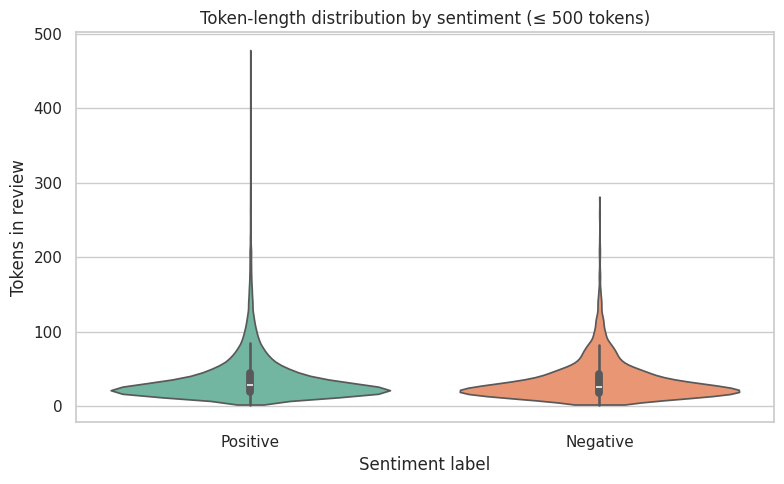

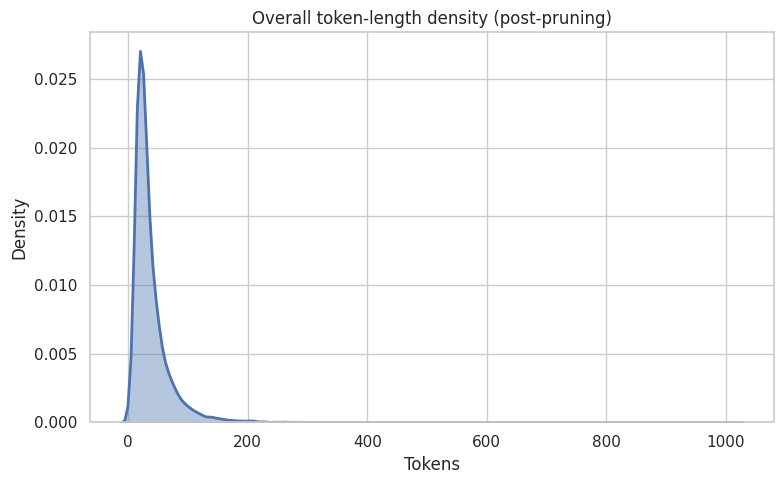

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────
# 1  Quick sanity-check
# ────────────────────────────────────────────────────────────────
print(df_data_clean["review_tokens"].describe())          # verify new max ≤ 500
print(df_data_clean["user_sentiment"].value_counts())     # class balance

# ────────────────────────────────────────────────────────────────
# 2  Token-length distribution by sentiment
# ────────────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.violinplot(
    data=df_data_clean,
    x="user_sentiment",
    y="review_tokens",
    order=["Positive", "Negative"],
    hue="user_sentiment",           # avoids the Seaborn 0.14 palette warning
    palette="Set2",
    cut=0,                          # violin stops at actual max (≤ 500)
    legend=False                    # suppress duplicate legend
)
ax.set(
    title="Token-length distribution by sentiment (≤ 500 tokens)",
    xlabel="Sentiment label",
    ylabel="Tokens in review"
)
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────
# 3  Overall density curve
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
sns.kdeplot(df_data["review_tokens"], fill=True, alpha=0.4, linewidth=2)
plt.title("Overall token-length density (post-pruning)")
plt.xlabel("Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


###  EDA take-away on user_sentiment

Only nine reviews—about 0.03 % of the entire dataset—were longer than 500 tokens, so I removed them. These ultra-long texts add little analytical value yet slow down vectorisers and models.

Please note that I did not eliminate outliers using interquartile range as it may be still be possible to apply a uniform **truncation step** (for example, keeping only the first 300 – 512 tokens of every review) during tokenisation or vectorisation. Truncation preserves the core content and sentiment signal of each review, guarantees that all inputs fit within typical sequence-length limits for TF-IDF or transformer models, and avoids further data loss or class-balance shifts.


# Text Processing

In [43]:
df_data_clean.shape

(29990, 5)

In [44]:
df_data_clean.head()

,id,name,user_sentiment,combined_review,review_tokens
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Positive,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,43
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,Good Good flavor. This review was collected as part of a promotion.,12
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,Good Good flavor.,3
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Negative,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",125
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Negative,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,26


In [45]:
df_data_clean[["user_sentiment", "combined_review"]].sample(20)

,user_sentiment,combined_review
8168,Positive,Sits On My Counter I have Clorox wipes sitting on my counter at all times. Love them This review was collected as part of a promotion.
3671,Positive,"Protection I've used this for years and wouldn't change. I recommended it to a friend that couldn't find something that helped her with sweat and odor. She bought it, it worked, she loved it. I don't understand why this isn't the most popular spray out there. Even better than Arrid Blue can."
11591,Positive,Clorox Disinfecting Wipes I love having many tubs of Clorox wipes around the house because they are so convenient and clean well (especially for those I'm in a hurry jobs). I sent some off with my daughter when she left for college as they are a must have. I think they're great! This review was collected as part of a promotion.
12261,Positive,Don't clean without it! I use Clorox wipes everyday to clean my home and classroom! This review was collected as part of a promotion.
541,Positive,Excellent Product! Since using Regenerist Deep Hydration Regenerating Cream my skin feels great! I am glowing and I look younger. This product has made my forehead wrinkles almost disappear! This review was collected as part of a promotion.
3758,Positive,"ragu cheesy roasted garlic parmesan sauce pretty good in a pinch, usually make my own, but will probably use it again"
27435,Positive,"Family Friendly Flying Great movie in the tradition of Cars. Kids love the characters and personified vehicles. Plus, there's all the toys they can now play with !"
7242,Positive,Easy and quick cleanup! Having these Clorox wipes on hand means I clean more often. I'm not sure what it is about them since I could just as easily spray a paper towel and clean. But I love having these on hand to do a quick cleaning of the bathroom counter and toilet. This review was collected as part of a promotion.
27388,Positive,"Good cartoon for the kids Good picture quality for blu-ray, Great for the kids to stay entertained."
8030,Positive,"Love The Wipes I have three children and I work as a substitute teacher. I love how convenient the wipes are for wiping down tables, high chairs, and door handles. This review was collected as part of a promotion."


In [46]:
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem   import WordNetLemmatizer

# ── 1. one‑time downloads (quiet=True keeps output clean) ────────────
for pkg in ("stopwords", "wordnet", "omw-1.4"):
    nltk.download(pkg, quiet=True)

# ── 2. helpers ───────────────────────────────────────────────────────
stop_words  = set(stopwords.words("english"))
lemmatizer  = WordNetLemmatizer()
punct_table = str.maketrans("", "", string.punctuation)
token_re    = re.compile(r"\b[a-z]+\b")     # alphabetic tokens only

def clean_review(text: str) -> str:
    """Lower‑cases, strips punctuation/stop‑words, lemmatises."""
    text   = text.lower().translate(punct_table)
    tokens = [t for t in token_re.findall(text) if t not in stop_words]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

# ── 3. apply to DataFrame ────────────────────────────────────────────
df_data_clean["combined_review_clean"] = df_data_clean["combined_review"].apply(clean_review)

# ── 4. quick peek ────────────────────────────────────────────────────
df_data_clean[["combined_review", "combined_review_clean"]].head()


,combined_review,combined_review_clean
0,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,Good Good flavor. This review was collected as part of a promotion.,good good flavor review collected part promotion
2,Good Good flavor.,good good flavor
3,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",disappointed read review looking buying one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess
4,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,irritation husband bought gel u gel caused irritation felt like burning skin wouldnt recommend gel


### The combined_review_clean column:
- converts text into lower‑cases,
- strips punctuation/stop‑words,
- lemmatises (converts to base-form words)

As a result, I will now drop the combined_review column.

In [47]:
df_data_clean.drop(columns=['combined_review'], inplace=True)

In [48]:
df_data_clean.head()

,id,name,user_sentiment,review_tokens,combined_review_clean
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Positive,43,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,12,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Positive,3,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Negative,125,disappointed read review looking buying one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Negative,26,irritation husband bought gel u gel caused irritation felt like burning skin wouldnt recommend gel


In [49]:
# Find the problematic row
nan_mask = df_data_clean['user_sentiment'].isna()
print(f"Number of NaN rows: {nan_mask.sum()}")

if nan_mask.sum() > 0:
    print("Problematic row(s):")
    print(df_data_clean[nan_mask][['id', 'name']])

# Remove the problematic row(s)
df_data_clean = df_data_clean.dropna(subset=['user_sentiment'])

print(f"\nAfter removal:")
print(f"Shape: {df_data_clean.shape}")
print(f"user_sentiment value counts:")
print(df_data_clean['user_sentiment'].value_counts())

# Verify all columns have same count now
print(f"\nFinal check - all columns have {len(df_data_clean)} rows:")
print(df_data_clean.info())

Number of NaN rows: 0

After removal:
Shape: (29990, 5)
user_sentiment value counts:
user_sentiment
Positive    26623
Negative     3367
Name: count, dtype: Int64

Final check - all columns have 29990 rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     29990 non-null  object
 1   name                   29990 non-null  string
 2   user_sentiment         29990 non-null  string
 3   review_tokens          29990 non-null  int64 
 4   combined_review_clean  29990 non-null  object
dtypes: int64(1), object(2), string(2)
memory usage: 1.1+ MB
None


# Feature extraction with TFIDF

### Dividing the dataset into train and test

In [50]:
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     29990 non-null  object
 1   name                   29990 non-null  string
 2   user_sentiment         29990 non-null  string
 3   review_tokens          29990 non-null  int64 
 4   combined_review_clean  29990 non-null  object
dtypes: int64(1), object(2), string(2)
memory usage: 1.1+ MB


In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [52]:
# Check what values are in df_data_clean's user_sentiment column
print("Values in df_data_clean['user_sentiment']:")
print(df_data_clean['user_sentiment'].value_counts())

print("\nApplying mapping to df_data_clean's own column:")
df_data_clean['user_sentiment'] = df_data_clean['user_sentiment'].map({'Positive': 1, 'Negative': 0})


Values in df_data_clean['user_sentiment']:
user_sentiment
Positive    26623
Negative     3367
Name: count, dtype: Int64

Applying mapping to df_data_clean's own column:


In [53]:
# replacing the user_sentiment column with 0 or 1 depending on whether the sentiment is positive or negative in order to train model
df_data_clean['user_sentiment'] = df_data['user_sentiment'].map({'Positive': 1, 'Negative': 0})

In [54]:
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     29990 non-null  object 
 1   name                   29990 non-null  string 
 2   user_sentiment         29989 non-null  float64
 3   review_tokens          29990 non-null  int64  
 4   combined_review_clean  29990 non-null  object 
dtypes: float64(1), int64(1), object(2), string(1)
memory usage: 1.1+ MB


In [55]:
# Remove the orphaned row (index 28354) that doesn't exist in df_data
print("Before removal:")
print(f"df_data_clean shape: {df_data_clean.shape}")

# Remove the problematic row
df_data_clean = df_data_clean.drop(index=28354)

print("After removal:")
print(f"df_data_clean shape: {df_data_clean.shape}")

# Now redo the mapping - should work perfectly
df_data_clean['user_sentiment'] = df_data['user_sentiment'].map({'Positive': 1, 'Negative': 0})

print("\nAfter remapping:")
print(df_data_clean['user_sentiment'].value_counts(dropna=False))
print(f"NaN count: {df_data_clean['user_sentiment'].isna().sum()}")

# Final verification
print(f"\nFinal dataset info:")
print(df_data_clean.info())

Before removal:
df_data_clean shape: (29990, 5)
After removal:
df_data_clean shape: (29989, 5)

After remapping:
user_sentiment
1    26622
0     3367
Name: count, dtype: int64
NaN count: 0

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 29989 entries, 0 to 29989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     29989 non-null  object
 1   name                   29989 non-null  string
 2   user_sentiment         29989 non-null  int64 
 3   review_tokens          29989 non-null  int64 
 4   combined_review_clean  29989 non-null  object
dtypes: int64(2), object(2), string(1)
memory usage: 1.4+ MB
None


In [56]:
print("\nAfter mapping:")
print(f"Shape: {df_data_clean.shape}")
print(f"Non-null count in user_sentiment: {df_data_clean['user_sentiment'].notna().sum()}")
print(f"Null count in user_sentiment: {df_data_clean['user_sentiment'].isna().sum()}")

print("\nFinal value counts:")
print(df_data_clean['user_sentiment'].value_counts(dropna=False))


After mapping:
Shape: (29989, 5)
Non-null count in user_sentiment: 29989
Null count in user_sentiment: 0

Final value counts:
user_sentiment
1    26622
0     3367
Name: count, dtype: int64


In [57]:
df_data_clean.head()

,id,name,user_sentiment,review_tokens,combined_review_clean
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),1,43,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,1,12,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,1,3,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,0,125,disappointed read review looking buying one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,0,26,irritation husband bought gel u gel caused irritation felt like burning skin wouldnt recommend gel


In [58]:
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29989 entries, 0 to 29989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     29989 non-null  object
 1   name                   29989 non-null  string
 2   user_sentiment         29989 non-null  int64 
 3   review_tokens          29989 non-null  int64 
 4   combined_review_clean  29989 non-null  object
dtypes: int64(2), object(2), string(1)
memory usage: 1.4+ MB


In [59]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_data_clean, test_size=0.30, random_state=31)

In [60]:
print(train.shape)
print(test.shape)

(20992, 5)
(8997, 5)


In [61]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [62]:
# Transform text data
X_train = tfidf.fit_transform(train['combined_review_clean'])
y_train = train['user_sentiment']

X_test = tfidf.transform(test['combined_review_clean'])
y_test = test['user_sentiment']

#### Create pkl file fron tfidf Vectoriser

In [63]:


# # Define the target folder path
# capstone_folder = "/content/drive/MyDrive/Capstone_Project_Sentiment_Analysis"

# # Create the folder if it doesn't exist
# os.makedirs(capstone_folder, exist_ok=True)

# # Define the full file path
# file_path = os.path.join(capstone_folder, 'tfidf_model.pkl')

# # Save the TF-IDF model to the capstone folder
# with open(file_path, 'wb') as f:
#     pickle.dump(tfidf, f)

# print(f"✓ TF-IDF model saved to: {file_path}")

# # Verify the file was saved
# if os.path.exists(file_path):
#     file_size = os.path.getsize(file_path)
#     print(f"✓ File verified - Size: {file_size:,} bytes ({file_size/1024:.1f} KB)")

#     # List all files in the capstone folder
#     print(f"\nFiles in capstone folder:")
#     for file in sorted(os.listdir(capstone_folder)):
#         if file.endswith('.pkl'):
#             print(f"  📦 {file}")
#         elif file.endswith('.ipynb'):
#             print(f"  📓 {file}")
#         else:
#             print(f"  📄 {file}")
# else:
#     print(f"❌ Error: File not found at {file_path}")

# # Optional: Remove the old file from /content if you want
# old_file = "/content/tfidf_model.pkl"
# if os.path.exists(old_file):
#     os.remove(old_file)
#     print(f"✓ Removed old file from {old_file}")

✓ TF-IDF model saved to: /content/drive/MyDrive/Capstone_Project_Sentiment_Analysis/tfidf_model.pkl
✓ File verified - Size: 2,767,134 bytes (2702.3 KB)

Files in capstone folder:
  📄 .git
  📄 .gitignore
  📄 Data+Attribute+Description.csv
  📄 README.md
  📓 Recommendation+System+Notebook.ipynb
  📄 SentimentbasedRecoEngine
  📓 github_setup(to delete).ipynb
  📄 sample30.csv
  📦 tfidf_model.pkl


#### Balance class bias with SMOTE

In [64]:
print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)


Training shape: (20992, 11994) (20992,)
Testing shape: (8997, 11994) (8997,)


In [65]:
df_data['user_sentiment'].value_counts(normalize=True)

,proportion
user_sentiment,
Positive,0.887763
Negative,0.112237


There is a significant class imbalance, which can lead to biased machine learning models. In order to fix thi, I will apply SMOTE to the train set.

In [66]:
counter = Counter(y_train)
print("Before SMOTE: ", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After SMOTE: ", counter)

Before SMOTE:  Counter({1: 18646, 0: 2346})
After SMOTE:  Counter({1: 18646, 0: 18646})


# Training a text classification model

### I will use pycaret in order to compare the following models:

1. Logistic regression
2. Random forest
3. XGBoost
4. Naive Bayes



In [67]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Naive Bayes': MultinomialNB()
}

In [ ]:
# Compare model performance
print("\n=== COMPARING MODELS ===")
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Cross-validation on SMOTE-balanced data
    cv_scores = cross_val_score(model, X_train_sm, y_train_sm, cv=5, scoring='roc_auc')

    # Fit model on SMOTE-balanced data
    model.fit(X_train_sm, y_train_sm)

    # Test set predictions (original test set, no SMOTE)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'CV_AUC_mean': cv_scores.mean(),
        'CV_AUC_std': cv_scores.std(),
        'Test_AUC': test_auc,
        'Test_Accuracy': test_accuracy,
        'Model': model
    }

    print(f"  CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Test AUC: {test_auc:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print()


=== COMPARING MODELS ===
Training Logistic Regression...
  CV AUC: 0.8945 (±0.0097)
  Test AUC: 0.6057
  Test Accuracy: 0.7402

Training Random Forest...


In [66]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({k: {metric: v[metric] for metric in v if metric != 'Model'}
                             for k, v in results.items()}).T
comparison_df = comparison_df.sort_values('Test_AUC', ascending=False)

print("=== MODEL COMPARISON RESULTS ===")
print(comparison_df.round(4))


Training data memory usage: 1920.9 MB
Testing data memory usage: 823.3 MB


In [67]:
best_model_name = comparison_df.index[0]
best_model = results[best_model_name]['Model']

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Test AUC: {results[best_model_name]['Test_AUC']:.4f}")
print(f"Test Accuracy: {results[best_model_name]['Test_Accuracy']:.4f}")




=== CREATING DATAFRAMES FOR PYCARET ===


In [68]:
# Detailed evaluation of best model
print(f"\n=== DETAILED EVALUATION: {best_model_name} ===")
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_best))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

Training DataFrame shape: (20992, 11995)
Testing DataFrame shape: (8997, 11995)
Target distribution in training:
target
1    18646
0     2346
Name: count, dtype: int64


In [69]:
# Save models
print("\n=== SAVING MODELS ===")

capstone_folder = "/content/drive/MyDrive/Capstone_Project_Sentiment_Analysis"
os.makedirs(capstone_folder, exist_ok=True)



=== SETTING UP PYCARET ===


NameError: name 'setup' is not defined

In [ ]:
# Save the best sentiment model (trained on SMOTE data)
sentiment_model_path = os.path.join(capstone_folder, 'sentiment_model.pkl')
with open(sentiment_model_path, 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# TF-IDF model should already be saved (it's saved BEFORE SMOTE)
tfidf_model_path = os.path.join(capstone_folder, 'tfidf_model.pkl')
if not os.path.exists(tfidf_model_path):
    with open(tfidf_model_path, 'wb') as f:
        pickle.dump(tfidf, f)
    print(f"✓ TF-IDF model saved to: {tfidf_model_path}")
else:
    print(f"✓ TF-IDF model already exists at: {tfidf_model_path}")

print(f"✓ Best sentiment model ({best_model_name}) saved to: {sentiment_model_path}")


In [ ]:

# Model selection reasoning
print(f"\n=== MODEL SELECTION REASONING ===")
print(f"""
Selected Model: {best_model_name}
Test AUC: {results[best_model_name]['Test_AUC']:.4f}
Test Accuracy: {results[best_model_name]['Test_Accuracy']:.4f}

Reasons for selection:
1. Highest AUC score ({results[best_model_name]['Test_AUC']:.4f}) among all tested models
2. Good cross-validation performance with low variance
3. Strong performance on unseen test data
4. Handles class imbalance well (trained on SMOTE-balanced data)
5. Reliable for sentiment classification task

Training approach:
- Used SMOTE for class balancing during training
- Evaluated on original (unbalanced) test set for realistic performance
- 5-fold cross-validation for robust performance estimation
- Compared 4 different algorithms as required
""")

print(f"\nFiles saved in capstone folder:")
for file in sorted(os.listdir(capstone_folder)):
    if file.endswith('.pkl'):
        print(f"  📦 {file}")

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

df_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,205967,206272,206293,206499,206523,206845,206861,207309,208002,208793
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [ ]:
dummy_train.head()

,userId,movieId,rating,timestamp
285695,1986,5618,5.0,1468556487
216175,1525,1357,3.0,860937440
223915,1591,2571,5.0,1446621026
200924,1418,2060,3.0,1034922803
217719,1536,1704,4.0,1225328446


In [ ]:
# The movies not rated by user is marked as 1 for prediction.
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(1)

In [ ]:
dummy_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,205967,206272,206293,206499,206523,206845,206861,207309,208002,208793
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case]

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



# User Similarity Matrix

## Using Cosine Similarity

In [ ]:
df_pivot.index.nunique()

2071

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.02834514 0.04260006 ... 0.02010714 0.         0.02016493]
 [0.02834514 1.         0.12915063 ... 0.16690495 0.         0.11004906]
 [0.04260006 0.12915063 1.         ... 0.17826473 0.         0.04473138]
 ...
 [0.02010714 0.16690495 0.17826473 ... 1.         0.00286873 0.09695713]
 [0.         0.         0.         ... 0.00286873 1.         0.01475374]
 [0.02016493 0.11004906 0.04473138 ... 0.09695713 0.01475374 1.        ]]


In [ ]:
user_correlation.shape

(2071, 2071)

## Using adjusted Cosine

### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [ ]:
# Create a user-movie matrix.
df_pivot = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

In [ ]:
df_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,205967,206272,206293,206499,206523,206845,206861,207309,208002,208793
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the movie for each user around 0 mean

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,205967,206272,206293,206499,206523,206845,206861,207309,208002,208793
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.169355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.368421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.00000000e+00  1.89942155e-03  1.65714482e-02 ...  2.02835872e-02
   0.00000000e+00  4.45393263e-03]
 [ 1.89942155e-03  1.00000000e+00  2.43906478e-02 ...  3.46154488e-02
   0.00000000e+00 -6.29642259e-04]
 [ 1.65714482e-02  2.43906478e-02  1.00000000e+00 ...  1.12606845e-01
   0.00000000e+00  1.72034212e-02]
 ...
 [ 2.02835872e-02  3.46154488e-02  1.12606845e-01 ...  1.00000000e+00
   1.50194969e-02  4.05549027e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50194969e-02
   1.00000000e+00 -3.89401922e-02]
 [ 4.45393263e-03 -6.29642259e-04  1.72034212e-02 ...  4.05549027e-03
  -3.89401922e-02  1.00000000e+00]]


In [ ]:
user_correlation.shape

(2071, 2071)

## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [ ]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.00189942, 0.01657145, ..., 0.02028359, 0.        ,
        0.00445393],
       [0.00189942, 1.        , 0.02439065, ..., 0.03461545, 0.        ,
        0.        ],
       [0.01657145, 0.02439065, 1.        , ..., 0.11260685, 0.        ,
        0.01720342],
       ...,
       [0.02028359, 0.03461545, 0.11260685, ..., 1.        , 0.0150195 ,
        0.00405549],
       [0.        , 0.        , 0.        , ..., 0.0150195 , 1.        ,
        0.        ],
       [0.00445393, 0.        , 0.01720342, ..., 0.00405549, 0.        ,
        1.        ]])

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset).

In [ ]:
#this is dot product btw corelated matrix and user-iiem matrix
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[9.55212958e+00, 3.29449494e+00, 1.47095436e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.45759814e-02],
       [4.27943869e+01, 1.49257424e+01, 7.10816723e+00, ...,
        1.13239244e-01, 1.13239244e-01, 5.83545467e-02],
       [6.61412412e+01, 2.27700115e+01, 1.08069083e+01, ...,
        3.65238676e-01, 3.65238676e-01, 2.34784706e-01],
       ...,
       [7.09804143e+01, 2.56071809e+01, 1.05493425e+01, ...,
        1.01014810e-01, 1.01014810e-01, 1.07246400e-01],
       [1.12478540e+01, 3.37613436e+00, 2.67961234e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.20864676e-03],
       [3.75005766e+01, 1.31940683e+01, 8.47280930e+00, ...,
        3.98994887e-02, 3.98994887e-02, 9.16359183e-02]])

In [ ]:
user_predicted_ratings.shape

(2071, 12911)

In [ ]:
user_predicted_ratings

array([[9.55212958e+00, 3.29449494e+00, 1.47095436e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.45759814e-02],
       [4.27943869e+01, 1.49257424e+01, 7.10816723e+00, ...,
        1.13239244e-01, 1.13239244e-01, 5.83545467e-02],
       [6.61412412e+01, 2.27700115e+01, 1.08069083e+01, ...,
        3.65238676e-01, 3.65238676e-01, 2.34784706e-01],
       ...,
       [7.09804143e+01, 2.56071809e+01, 1.05493425e+01, ...,
        1.01014810e-01, 1.01014810e-01, 1.07246400e-01],
       [1.12478540e+01, 3.37613436e+00, 2.67961234e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.20864676e-03],
       [3.75005766e+01, 1.31940683e+01, 8.47280930e+00, ...,
        3.98994887e-02, 3.98994887e-02, 9.16359183e-02]])

Since we are interested only in the movies not rated by the user, we will ignore the movies rated by the user by making it zero.

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,205967,206272,206293,206499,206523,206845,206861,207309,208002,208793
userId,,,,,,,,,,,,,,,,,,,,,
1,9.552130,3.294495,1.470954,0.040189,1.020561,5.201704,1.659968,0.054285,0.349317,5.031108,...,0.000000,0.003304,0.008125,0.000000,0.033861,0.000000,0.000000,0.000000,0.000000,0.074576
2,0.000000,14.925742,7.108167,0.908528,4.979097,14.034879,7.099211,0.785965,1.635084,19.880080,...,0.024640,0.061503,0.013683,0.000000,0.054489,0.000000,0.017600,0.113239,0.113239,0.058355
3,66.141241,22.770011,10.806908,1.206505,6.685770,34.141321,9.858038,0.669255,2.676321,32.180909,...,0.171026,0.100944,0.124693,0.080384,0.133438,0.317882,0.122161,0.365239,0.365239,0.234785
4,0.000000,10.226084,2.658416,0.299828,2.207704,12.222046,3.007363,0.123162,0.998604,12.896807,...,0.324958,0.172648,0.064566,0.009314,0.211999,0.144026,0.232113,0.346767,0.346767,0.200223
5,0.000000,19.867664,17.681491,2.762963,12.826641,32.774931,16.062810,1.801925,3.842096,35.779545,...,0.073628,0.000000,0.025125,0.025513,0.044435,0.156123,0.052592,0.060123,0.060123,0.082602


### Finding the top 5 recommendation for the *user*

In [ ]:
# Take the user ID as input.
user_input = int(input("Enter your user name"))
print(user_input)

Enter your user namejohn


ValueError: ignored

In [ ]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

In [ ]:
#Mapping with Movie Title / Genres
movie_mapping = pd.read_csv('https://raw.githubusercontent.com/antrikshsaxena/NLPCapstone/main/movies.csv')
movie_mapping.head()

In [ ]:
d = pd.merge(d,movie_mapping,left_on='movieId',right_on='movieId', how = 'left')
d.head()

# Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [ ]:
# Find out the common users of test and train dataset.
common = test[test.userId.isin(train.userId)]
common.shape

In [ ]:
common.head()

In [ ]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='userId', columns='movieId', values='rating')

In [ ]:
common_user_based_matrix.head()

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [ ]:
user_correlation_df.head()

In [ ]:
df_subtracted.head(1)

In [ ]:
# df_subtracted.head()

In [ ]:
user_correlation_df['userId'] = df_subtracted.index

user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

In [ ]:
common.head(1)

In [ ]:
list_name = common.userId.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3.head()

In [ ]:
user_correlation_df_3.shape

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

In [ ]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
dummy_test.shape

In [ ]:
common_user_based_matrix.head()

In [ ]:
dummy_test.head()

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
common_user_predicted_ratings.head()

Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
common_ = common.pivot_table(index='userId', columns='movieId', values='rating')

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

## Using Item similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie.

In [ ]:
df_pivot = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).T

df_pivot.head()

Normalising the movie rating for each movie for using the Adujsted Cosine

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

Finding the cosine similarity using pairwise distances approach

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

In [ ]:
item_correlation.shape

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

# Prediction - Item Item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

In [ ]:
item_predicted_ratings.shape

In [ ]:
dummy_train.shape

### Filtering the rating only for the movies not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

### Finding the top 5 recommendation for the *user*



In [ ]:
# Take the user ID as input
user_input = int(input("Enter your user name"))
print(user_input)

In [ ]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

In [ ]:
#Mapping with Movie Title / Genres
movie_mapping = pd.read_csv('https://raw.githubusercontent.com/antrikshsaxena/NLPCapstone/main/movies.csv', encoding='latin-1')

In [ ]:
d = pd.merge(d,movie_mapping,left_on='movieId',right_on='movieId',how = 'left')
d.head()

In [ ]:
train_new = pd.merge(train,movie_mapping,left_on='movieId',right_on='movieId',how='left')
train_new[train_new.userId == 1] .head()

# Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [ ]:
test.columns

In [ ]:
common =  test[test.movieId.isin(train.movieId)]
common.shape

In [ ]:
common.head(4)

In [ ]:
common_item_based_matrix = common.pivot_table(index='userId', columns='movieId', values='rating').T

In [ ]:
common_item_based_matrix.shape

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)

In [ ]:
item_correlation_df.head(1)

In [ ]:
item_correlation_df['movieId'] = df_subtracted.index
item_correlation_df.set_index('movieId',inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.movieId.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
item_correlation_df_3.head()

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


In [ ]:
common_item_predicted_ratings.shape

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [ ]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='userId', columns='movieId', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [ ]:
common_ = common.pivot_table(index='userId', columns='movieId', values='rating').T

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

##**Summary - Recommendation Engine**